In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statistics


In [2]:
##startup
## Connect to the Database
from sqlalchemy import Column, Integer, String, Date, ForeignKey, Boolean, Float
import sqlalchemy as db
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relation, sessionmaker
from sqlalchemy.orm import sessionmaker
import sys
sys.path.append('..\\')
from DB.Schema import Team, Player, Injury, Quarterback, WideReceiver, RunningBack, TightEnd, Kicker, Defense

engine = db.create_engine('sqlite:///..\\DB\\ff.db')
connection = engine.connect()
Base = declarative_base()

Session = sessionmaker(bind=engine, autoflush=False)
Session.configure(bind=engine, autoflush=False)
session = Session()

In [3]:
QB_COLUMN_WHITELIST = ['pts_half_ppr', 'pass_lng', 'off_snp', 'gs', 'cmp_pct', 'pass_fd', 'pass_sack', 'tm_off_snp', 'wind_speed', 'gms_active',
                      'pass_cmp', 'pts_half_ppr', 'pass_rtg', 'pass_sack_yds', 'tm_def_snp', 'rush_ypa', 'temperature', 'pass_att', 
                       'pass_inc', 'pass_ypa', 'rush_att', 'pass_td', 'rush_lng', 'tm_st_snp', 'rush_yd', 'pass_yd', 'rush_td', 'fum_lost',
                       'humidity', 'fum', 'pass_ypc']
QB_COLUMN_WHITELIST.sort()

In [4]:
## 3 dimensional features matrix 
# qbs = session.query(Quarterback)
# qb_id = set()
# seasons = ['2017', '2018']
# seasons_available = 2
# games_per_season = 16
# feature_columns = len(QB_COLUMN_WHITELIST)

# for qb in qbs:
#     qb_id.add(qb.player_id)
    
# shape = (len(qb_id), (seasons_available * games_per_season), (feature_columns))

# features = np.zeros(shape)

# dependent_index = 0
# index = 0
# for i in qb_id:
#     qb_stats = session.query(Quarterback).filter(Quarterback.player_id == i).order_by(Quarterback.season, Quarterback.week)
#     week = 0
#     for stat in qb_stats:
#         vals = np.zeros(feature_columns)
#         feature_index = 1
#         for column in dir(stat):
#             if column in QB_COLUMN_WHITELIST:
#                 var = getattr(stat, column)
#                 if var is not None:
#                     if column == 'pts_half_ppr':
#                         vals[dependent_index] = var
#                     else:
#                         vals[feature_index] = var
#                         feature_index += 1
#                 else:
#                     feature_index += 1
#         features[index][week] = vals
#         week += 1
#     index += 1

In [4]:
## 2 dimensional features matrix
# get rid of people that didnt play
qb_stats = session.query(Quarterback).filter(Quarterback.pass_att != 0).order_by(Quarterback.season, Quarterback.week).all()
seasons = ['2017', '2018']
seasons_available = 2
games_per_season = 16
feature_columns = len(QB_COLUMN_WHITELIST)
    
shape = ((len(qb_stats)), (feature_columns))

features = np.zeros(shape)

dependent_index = 0
week = 0
for stat in qb_stats:
    vals = np.zeros(feature_columns)
    feature_index = 1
    for column in dir(stat):
        if column in QB_COLUMN_WHITELIST:
            var = getattr(stat, column)
            if var is not None:
                if column == 'pts_half_ppr':
                    vals[dependent_index] = var
                else:
                    vals[feature_index] = var
                    feature_index += 1
            else:
                feature_index += 1
    features[week] = vals
    week += 1


In [6]:
pat_mahomes = session.query(Quarterback).filter(Quarterback.player_id == '4046', Quarterback.season == '2018', Quarterback.week == 1).first()
for column in dir(pat_mahomes):
    if column in QB_COLUMN_WHITELIST:
        print(column, ": ", getattr(pat_mahomes, column))

cmp_pct :  55.6
fum :  None
fum_lost :  None
gms_active :  1.0
gs :  1.0
humidity :  66.0
off_snp :  56.0
pass_att :  27.0
pass_cmp :  15.0
pass_fd :  6.0
pass_inc :  12.0
pass_lng :  58.0
pass_rtg :  127.47
pass_sack :  1.0
pass_sack_yds :  None
pass_td :  4.0
pass_yd :  256.0
pass_ypa :  9.5
pass_ypc :  17.1
pts_half_ppr :  28.3
rush_att :  5.0
rush_lng :  8.0
rush_td :  None
rush_yd :  21.0
rush_ypa :  4.2
temperature :  74.0
tm_def_snp :  82.0
tm_off_snp :  56.0
tm_st_snp :  24.0
wind_speed :  4.0


In [5]:
print(features.shape)
sample_factor = 0.8

#separate data into training and testing data
features = pd.DataFrame(features)
train_dataset = features.sample(frac=sample_factor, random_state=0)
test_dataset = features.drop(train_dataset.index)

(1148, 31)


In [6]:
#separate features and labels
train_features = pd.DataFrame(train_dataset.to_numpy()[:, 1:])
train_labels = pd.DataFrame(train_dataset.to_numpy()[:, 0])

test_features = pd.DataFrame(test_dataset.to_numpy()[:, 1:])
test_labels = pd.DataFrame(test_dataset.to_numpy()[:, 0])

In [7]:
#Normalize data
scaler = StandardScaler().fit(train_features)
scaled_train_features = scaler.transform(train_features)
scaled_test_features = scaler.transform(test_features)


In [8]:
#very simple model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_features.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [9]:
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1984      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
_________________________________________________________________


In [10]:
example_batch = scaled_train_features[:10]
result = model.predict(example_batch)
print(result)

[[ 0.46748772]
 [-0.00144832]
 [-0.04870343]
 [ 0.58611953]
 [-0.2836972 ]
 [ 0.24552931]
 [ 0.7711885 ]
 [ 1.0288838 ]
 [ 0.5059494 ]
 [ 0.02337301]]


In [11]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  scaled_train_features, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

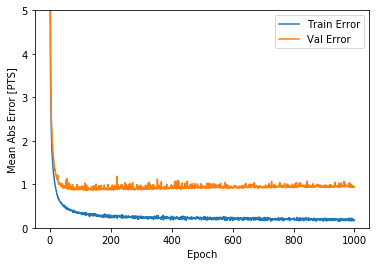

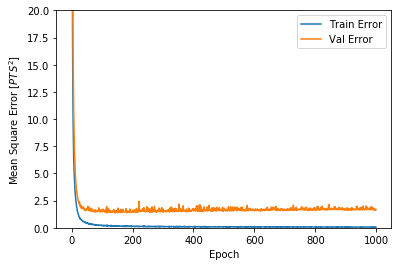

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [PTS]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$PTS^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)